# SPINN artifact problem

In [ ]:
from setproctitle import setproctitle
setproctitle("SPINN")

In [ ]:
import os

In [ ]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
# from cmspinn.potential_field import cal_and_save_potential_boundary_for_spinn

In [ ]:
import jax 
import jax.numpy as jnp
import optax
import numpy as np 
import matplotlib.pyplot as plt
import time 
import pickle
from tqdm import trange

In [ ]:
from cmspinn.spinn_jax import SPINN3d, update_model

In [ ]:
import glob
import time
from pathlib import Path

In [ ]:
from functools import partial
from jax import jvp

In [ ]:
import logging

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
for hdlr in logger.handlers[:]:  # remove all old handlers
    logger.removeHandler(hdlr)
logger.addHandler(logging.FileHandler("{0}/{1}.log".format('/userhome/jeon_mg/workspace/_data', "info_log")))  # set the new file handler
logger.addHandler(logging.StreamHandler())  # set the new console handler

In [ ]:
n_max_x = 2*(344/344)
n_max_y = 2*(224/344)
n_max_z = 2*(160/344)

logger.info(f'n_max_x: {n_max_x}, n_max_y: {n_max_y}, n_max_z: {n_max_z}')

n_max_x: 2.0, n_max_y: 1.302325581395349, n_max_z: 0.9302325581395349


In [ ]:
def curlx(apply_fn, params, x, y, z):
    # curl vector w/ forward-mode AD
    # w_x = uz_y - uy_z
    vec_z = jnp.ones(z.shape)
    vec_y = jnp.ones(y.shape)
    uy_z = jvp(lambda z: apply_fn(params, x, y, z)[1], (z,), (vec_z,))[1]
    uz_y = jvp(lambda y: apply_fn(params, x, y, z)[2], (y,), (vec_y,))[1]
    wx = uz_y - uy_z
    return wx


def curly(apply_fn, params, x, y, z):
    # curl vector w/ forward-mode AD
    # w_y = ux_z - uz_x
    vec_z = jnp.ones(z.shape)
    vec_x = jnp.ones(x.shape)
    ux_z = jvp(lambda z: apply_fn(params, x, y, z)[0], (z,), (vec_z,))[1]
    uz_x = jvp(lambda x: apply_fn(params, x, y, z)[2], (x,), (vec_x,))[1]
    wy = ux_z - uz_x
    return wy

def curlz(apply_fn, params, x, y, z):
    # curl vector w/ forward-mode AD
    # w_z = uy_x - ux_y
    vec_y = jnp.ones(y.shape)
    vec_x = jnp.ones(x.shape)
    ux_y = jvp(lambda y: apply_fn(params, x, y, z)[0], (y,), (vec_y,))[1]
    uy_x = jvp(lambda x: apply_fn(params, x, y, z)[1], (x,), (vec_x,))[1]
    wz = uy_x - ux_y
    return wz

In [ ]:
@partial(jax.jit, static_argnums=(0,))
def apply_model_spinn(apply_fn, params, train_boundary_data):
    def residual_loss(params, x, y, z):
        # calculate u
        Bx, By, Bz = apply_fn(params, x, y, z)
        B = jnp.stack([Bx, By, Bz], axis=-1)
        
        # calculate J
        Jx = curlx(apply_fn, params, x, y, z)
        Jy = curly(apply_fn, params, x, y, z)
        Jz = curlz(apply_fn, params, x, y, z)
        J = jnp.stack([Jx, Jy, Jz], axis=-1)

        JxB = jnp.cross(J, B, axis=-1) 

        #-----------------------------------------------------------
        # loss_ff = jnp.sum(JxB**2, axis=-1)
        loss_ff = jnp.sum(JxB**2, axis=-1) / (jnp.sum(B**2, axis=-1) + 1e-7)
        loss_ff = jnp.mean(loss_ff)

        # loss_ff = jnp.mean(JxB**2)

        # loss_ff = jnp.mean(loss_ff)
        #-----------------------------------------------------------

        # tangent vector dx/dx
        # assumes x, y, z have same shape (very important)
        vec_x = jnp.ones(x.shape)
        vec_y = jnp.ones(y.shape)
        vec_z = jnp.ones(z.shape)
        
        Bx_x = jvp(lambda x: apply_fn(params, x, y, z)[0], (x,), (vec_x,))[1]
        # Bx_y = jvp(lambda y: apply_fn(params, x, y, z)[0], (y,), (vec,))[1]
        # Bx_z = jvp(lambda z: apply_fn(params, x, y, z)[0], (z,), (vec,))[1]

        # By_x = jvp(lambda x: apply_fn(params, x, y, z)[1], (x,), (vec,))[1]
        By_y = jvp(lambda y: apply_fn(params, x, y, z)[1], (y,), (vec_y,))[1]
        # By_z = jvp(lambda z: apply_fn(params, x, y, z)[1], (z,), (vec,))[1]

        # Bz_x = jvp(lambda x: apply_fn(params, x, y, z)[2], (x,), (vec,))[1]
        # Bz_y = jvp(lambda y: apply_fn(params, x, y, z)[2], (y,), (vec,))[1]
        Bz_z = jvp(lambda z: apply_fn(params, x, y, z)[2], (z,), (vec_z,))[1]

        divB = Bx_x + By_y + Bz_z
        
        #-----------------------------------------------------------
        # loss_div = jnp.sum((divB)**2, axis=-1)
        # loss_div = jnp.mean(loss_div)

        loss_div = jnp.mean((divB)**2)
        #-----------------------------------------------------------

        loss = loss_ff + loss_div

        return loss

    def boundary_loss(params, x, y, z, *boundary_data):
        
        # loss = 0.
        # for i in np.arange(4):
        #     boundary_data_batched = boundary_batches[i, :, :, :]
        #     xb = boundary_data_batched[:, 0, :][:, 0].reshape(-1, 1)
        #     yb = boundary_data_batched[:, 0, :][:, 1].reshape(-1, 1)
        #     zb = boundary_data_batched[:, 0, :][:, 2].reshape(-1, 1)

        #     Bx, By, Bz = apply_fn(params, xb, yb, zb)
        #     # Bx, By, Bz = Bx.reshape(-1, 1), By.reshape(-1, 1), Bz.reshape(-1, 1)

        #     Bxb = boundary_data_batched[:, 1, :][:, 0].reshape(-1, 1)
        #     Byb = boundary_data_batched[:, 1, :][:, 1].reshape(-1, 1)
        #     Bzb = boundary_data_batched[:, 1, :][:, 2].reshape(-1, 1)

        #     Bxb_mesh, Byb_mesh, Bzb_mesh = jnp.meshgrid(Bxb.ravel(), Byb.ravel(), Bzb.ravel(), indexing='ij')
            
        #     loss += jnp.mean((Bx - Bxb_mesh)**2) + jnp.mean((By - Byb_mesh)**2) + jnp.mean((Bz - Bzb_mesh)**2)

        #0 z=0   bottom
        #1 z=2   top                  
        #2 x=0   lateral_1            
        #3 x=2   lateral_2            
        #4 y=0   lateral_3            
        #5 y=2   lateral_4            

        b_bottom, bp_top, bp_lateral_1, bp_lateral_2, bp_lateral_3, bp_lateral_4 = boundary_data
        

        loss = 0.
        Bx, By, Bz = apply_fn(params,  x[0], y[0], z[0])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += (1/6)*jnp.mean((Bx - b_bottom[:, :, 0])**2) + jnp.mean((By - b_bottom[:, :, 1])**2) + jnp.mean((Bz - b_bottom[:, :, 2])**2)

        #0 z=0   bottom
        #1 z=2   top                  -> Only normal(Bz), Bx=0, By=0
        #2 x=0   lateral_1            -> Only tangential(By, Bz), Bx=0
        #3 x=2   lateral_2            -> Only tangential(By, Bz), Bx=0
        #4 y=0   lateral_3            -> Only tangential(Bx, Bz), By=0
        #5 y=2   lateral_4            -> Only tangential(Bx, Bz), By=0

        # Bx, By, Bz = apply_fn(params,  x[1], y[1], z[1])
        # Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        # loss += jnp.mean(Bx**2) + jnp.mean(By**2)

        # Bx, By, Bz = apply_fn(params,  x[2], y[2], z[2])
        # Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        # loss += jnp.mean(Bx**2)

        # Bx, By, Bz = apply_fn(params,  x[3], y[3], z[3])
        # Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        # loss += jnp.mean(Bx**2)
        
        # Bx, By, Bz = apply_fn(params,  x[4], y[4], z[4])
        # Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        # loss += jnp.mean(By**2)

        # Bx, By, Bz = apply_fn(params,  x[5], y[5], z[5])
        # Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        # loss += jnp.mean(By**2)

        Bx, By, Bz = apply_fn(params,  x[1], y[1], z[1])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += (1/6)*jnp.mean((Bx - bp_top[:, :, 0])**2) + jnp.mean((By - bp_top[:, :, 1])**2) + jnp.mean((Bz - bp_top[:, :, 2])**2)

        Bx, By, Bz = apply_fn(params,  x[2], y[2], z[2])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += (1/6)*jnp.mean((Bx - bp_lateral_1[:, :, 0])**2) + jnp.mean((By - bp_lateral_1[:, :, 1])**2) + jnp.mean((Bz - bp_lateral_1[:, :, 2])**2)

        Bx, By, Bz = apply_fn(params,  x[3], y[3], z[3])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += (1/6)*jnp.mean((Bx - bp_lateral_2[:, :, 0])**2) + jnp.mean((By - bp_lateral_2[:, :, 1])**2) + jnp.mean((Bz - bp_lateral_2[:, :, 2])**2)

        Bx, By, Bz = apply_fn(params,  x[4], y[4], z[4])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += (1/6)*jnp.mean((Bx - bp_lateral_3[:, :, 0])**2) + jnp.mean((By - bp_lateral_3[:, :, 1])**2) + jnp.mean((Bz - bp_lateral_3[:, :, 2])**2)

        Bx, By, Bz = apply_fn(params,  x[5], y[5], z[5])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += (1/6)*jnp.mean((Bx - bp_lateral_4[:, :, 0])**2) + jnp.mean((By - bp_lateral_4[:, :, 1])**2) + jnp.mean((Bz - bp_lateral_4[:, :, 2])**2)

        
        return loss

    # unpack data
    train_data = train_boundary_data[0]
    boundary_data = train_boundary_data[1]
    xc, yc, zc, xb, yb, zb = train_data

    # isolate loss func from redundant arguments
    loss_fn = lambda params: residual_loss(params, xc, yc, zc) + boundary_loss(params, xb, yb, zb, *boundary_data)

    loss, gradient = jax.value_and_grad(loss_fn)(params)

    return loss, gradient

In [ ]:
@partial(jax.jit, static_argnums=(1, 2, 3, 4, 5))
def generate_train_data(key, nx, ny, nz, nc=None, spatial_norm=None):
    keys = jax.random.split(key, 4)
    xc = jax.random.uniform(keys[1], (nc, 1), minval=0., maxval=n_max_x)
    yc = jax.random.uniform(keys[2], (nc, 1), minval=0., maxval=n_max_y)
    zc = jax.random.uniform(keys[3], (nc, 1), minval=0., maxval=n_max_z)

#     # # boundary points
#     xb = [jnp.linspace(0, 1, nx).reshape(nx, 1)*nx / spatial_norm, # z=0   bottom
#           jnp.linspace(0, 1, nx).reshape(nx, 1)*nx / spatial_norm, # z=2   top
#           jnp.array([[0.]]) / spatial_norm,                     # x=0   lateral_1
#           jnp.array([[nx]]) / spatial_norm,                     # x=2   lateral_2
#           jnp.linspace(0, 1, nx).reshape(nx, 1)*nx / spatial_norm, # y=0   lateral_3
#           jnp.linspace(0, 1, nx).reshape(nx, 1)*nx / spatial_norm] # y=2   lateral_4

#     yb = [jnp.linspace(0, 1, ny).reshape(ny, 1)*ny / spatial_norm, 
#           jnp.linspace(0, 1, ny).reshape(ny, 1)*ny / spatial_norm, 
#           jnp.linspace(0, 1, ny).reshape(ny, 1)*ny / spatial_norm, 
#           jnp.linspace(0, 1, ny).reshape(ny, 1)*ny / spatial_norm, 
#           jnp.array([[0.]]) / spatial_norm, 
#           jnp.array([[ny]]) / spatial_norm]

#     zb = [jnp.array([[0.]]) / spatial_norm, 
#           jnp.array([[nz]]) / spatial_norm, 
#           jnp.linspace(0, 1, nz).reshape(nz, 1)*nz / spatial_norm, 
#           jnp.linspace(0, 1, nz).reshape(nz, 1)*nz / spatial_norm, 
#           jnp.linspace(0, 1, nz).reshape(nz, 1)*nz / spatial_norm, 
#           jnp.linspace(0, 1, nz).reshape(nz, 1)*nz / spatial_norm]

#     xc = jnp.linspace(0, n_max_x, nx).reshape(-1, 1)
#     yc = jnp.linspace(0, n_max_y, ny).reshape(-1, 1)
#     zc = jnp.linspace(0, n_max_z, nz).reshape(-1, 1)

    # # boundary points
    xb = [jnp.linspace(0, n_max_x, nx).reshape(-1, 1), # z=0   bottom
          jnp.linspace(0, n_max_x, nx).reshape(-1, 1), # z=2   top
          jnp.array([[0.]]),                     # x=0   lateral_1
          jnp.array([[n_max_x]]),                     # x=2   lateral_2
          jnp.linspace(0, n_max_x, nx).reshape(-1, 1), # y=0   lateral_3
          jnp.linspace(0, n_max_x, nx).reshape(-1, 1)] # y=2   lateral_4

    yb = [jnp.linspace(0, n_max_y, ny).reshape(-1, 1), 
          jnp.linspace(0, n_max_y, ny).reshape(-1, 1), 
          jnp.linspace(0, n_max_y, ny).reshape(-1, 1), 
          jnp.linspace(0, n_max_y, ny).reshape(-1, 1), 
          jnp.array([[0.]]), 
          jnp.array([[n_max_y]])]

    zb = [jnp.array([[0.]]), 
          jnp.array([[n_max_z]]), 
          jnp.linspace(0, n_max_z, nz).reshape(-1, 1), 
          jnp.linspace(0, n_max_z, nz).reshape(-1, 1), 
          jnp.linspace(0, n_max_z, nz).reshape(-1, 1), 
          jnp.linspace(0, n_max_z, nz).reshape(-1, 1)]

    return xc, yc, zc, xb, yb, zb

In [ ]:
class SPINN_Trainer:
    def __init__(self, output_path, BC_path, Nx, Ny, Nz, Nc, spatial_norm, b_norm, transfer_learning_path=None):
    # def __init__(self, output_path, BC_path, Nx, Ny, Nz, b_norm, transfer_learning_path=None):
        os.makedirs(output_path, exist_ok=True)
        
        features = 512
        n_layers = 8
        feat_sizes = tuple([features for _ in range(n_layers)]) 
        r = 512
        out_dim = 3 

        lr = 5e-4

        pos_enc = 0
        mlp = 'modified_mlp'

        parameters = {'feat_sizes' : feat_sizes, 
              'r' : r, 
              'out_dim' : out_dim, 
              'Nx' : Nx, 
              'Ny' : Ny, 
              'Nz' : Nz, 
              'b_norm' : b_norm,
              'pos_enc' : pos_enc,
              'mlp' : mlp,
              'lr': lr,
              'Nx': Nx,
              'Ny': Ny,
              'Nz': Nz}
        
        logger.info(parameters)
    
        parameters_path = os.path.join(output_path, "parameters.pickle")
        with open(parameters_path, "wb") as f:
            pickle.dump(parameters, f)


        seed = 111
        key = jax.random.PRNGKey(seed)
        key, subkey = jax.random.split(key, 2)

        model = SPINN3d(feat_sizes, r, out_dim, pos_enc=pos_enc, mlp=mlp)
        if transfer_learning_path is None:
            params = model.init(
                        subkey,
                        jnp.ones((Nx, 1)),
                        jnp.ones((Ny, 1)),
                        jnp.ones((Nz, 1))
                    )
            apply_fn = jax.jit(model.apply)
            optim = optax.adam(learning_rate=lr)
            state = optim.init(params)
        else:
            model.init(
                        subkey,
                        jnp.ones((Nx, 1)),
                        jnp.ones((Ny, 1)),
                        jnp.ones((Nz, 1))
                    )
            apply_fn = jax.jit(model.apply)
            with open(transfer_learning_path, 'rb') as f:
                params = pickle.load(f)

            optim = optax.adam(learning_rate=lr)
            state = optim.init(params)

        with open(BC_path, 'rb') as f:
            boundary_data = pickle.load(f)

        logger.info(Nc)

        train_data = generate_train_data(subkey, Nx, Ny, Nz, nc=Nc, spatial_norm=spatial_norm)
        # train_data = generate_train_data(subkey, Nx, Ny, Nz)
        train_boundary_data = [train_data, boundary_data]

        self.boundary_data = boundary_data

        self.apply_fn = apply_fn
        self.params = params
        self.train_boundary_data = train_boundary_data
        self.optim = optim
        self.state = state
        self.output_path = output_path

        self.Nx = Nx 
        self.Ny = Ny 
        self.Nz = Nz

        self.key = key

        self.Nc = Nc 
        self.spatial_norm = spatial_norm

    def train(self, total_iterations, log_iterations, loss_threshold=0.001, random_iter=100):
        params = self.params
        state = self.state

        losses = []
        logger.info('Complie Start')
        start = time.time()
        loss, gradient = apply_model_spinn(self.apply_fn, params, self.train_boundary_data)
        losses.append(loss.item())
        params, state = update_model(self.optim, gradient, params, state)
        runtime = time.time() - start
        logger.info(f'Complie End --> total: {runtime:.2f}sec')
        logger.info(f'Random iter: {random_iter}')

        start = time.time()
        for e in trange(1, total_iterations + 1):

            if e % random_iter == 0:
                # sample new input data
                key, subkey = jax.random.split(self.key, 2)
                train_data = generate_train_data(subkey, self.Nx, self.Ny, self.Nz, nc=self.Nc, spatial_norm=self.spatial_norm)
                self.train_boundary_data = [train_data, self.boundary_data]

            loss, gradient = apply_model_spinn(self.apply_fn, params, self.train_boundary_data)
            losses.append(loss.item())
            if loss.item() < loss_threshold:
                logger.info(f'Epoch: {e}/{total_iterations} --> loss: {loss:.8f} < {loss_threshold}')
                break
            
            params, state = update_model(self.optim, gradient, params, state)
            
            if e % log_iterations == 0:
                logger.info(f'Epoch: {e}/{total_iterations} --> total loss: {loss:.8f}')
                params_path = os.path.join(self.output_path, f"params_{e}.pickle")
                with open(params_path, "wb") as f:
                    pickle.dump(params, f)

        final_params_path = os.path.join(self.output_path, f"final_params.pickle")
        with open(final_params_path, "wb") as f:
            pickle.dump(params, f)

        np.save(os.path.join(self.output_path, 'losses.npy'), losses)

        runtime = time.time() - start
        logger.info(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(total_iterations-1)*1000):.2f}ms/iter.)')

In [ ]:
Nz = 160
b_norm = 2500
Nc = 128
spatial_norm = None

epochs = 5000
log_iter = 1000

series_epochs = 2000
series_log_iter = 100

loss_threshold = 0.0001

In [ ]:
b_bottom_paths = os.path.expanduser('~/workspace/_data/NOAA12673/b_bottom')
# b_bottom_list = sorted(glob.glob(os.path.join(b_bottom_paths, '*.npy')))


In [ ]:
import shutil 

In [ ]:
spinn_BC_path = os.path.join(Path(b_bottom_paths).parent, 'SPINN_BC')
spinn_output_path = os.path.join(Path(b_bottom_paths).parent, 'SPINN_artifact')
Path(spinn_output_path).mkdir(parents=True, exist_ok=True)

In [ ]:
# b_bottom_path = '/userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170906_083600.npy'
# spinn_output_path = '/userhome/jeon_mg/workspace/_data/NOAA12673/SPINN_energy/'
# spinn_BC_path = '/userhome/jeon_mg/workspace/_data/NOAA12673/SPINN_energy_BC/'
# try:
#     shutil.rmtree(spinn_BC_path)
# except:
#     pass
# os.makedirs(spinn_BC_path, exist_ok=True)

In [ ]:
b_bottom_path = '/userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170906_083600.npy'

In [ ]:
b_bottom_date = os.path.basename(b_bottom_path)[9:-4]

output_path = os.path.join(spinn_output_path, b_bottom_date)

BC_path = os.path.join(spinn_BC_path, f'b_BC_{b_bottom_date}.pickle')

with open(b_bottom_path, 'rb') as f:
    b_bottom = np.load(f)

Nx, Ny, _ = b_bottom.shape

In [ ]:
# cal_and_save_potential_boundary_for_spinn(b_bottom, Nz, b_norm, BC_path)

In [ ]:
try:
    shutil.rmtree(output_path)
except:
    pass

In [ ]:
tranier = SPINN_Trainer(output_path, BC_path, Nx, Ny, Nz, Nc, spatial_norm, b_norm, transfer_learning_path=None)
# tranier = SPINN_Trainer(output_path, BC_path, Nx, Ny, Nz, b_norm, transfer_learning_path=None)

{'feat_sizes': (512, 512, 512, 512, 512, 512, 512, 512), 'r': 512, 'out_dim': 3, 'Nx': 344, 'Ny': 224, 'Nz': 160, 'b_norm': 2500, 'pos_enc': 0, 'mlp': 'modified_mlp', 'lr': 0.0005}
Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


128


In [ ]:
tranier.train(epochs, log_iter, loss_threshold=loss_threshold)

Complie Start
Complie End --> total: 40.77sec
Random iter: 100
100%|██████████| 5000/5000 [02:31<00:00, 33.07it/s]
Runtime --> total: 151.24sec (30.25ms/iter.)


[<matplotlib.lines.Line2D>]

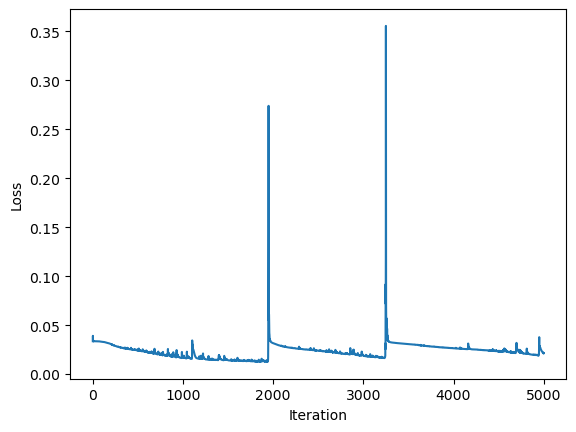

In [ ]:
fig, ax = plt.subplots()

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')


loss_path = os.path.join(output_path, 'losses.npy')

with open(loss_path, "rb") as f:
    losses = np.load(f)

ax.plot(losses)

In [ ]:
import numpy as np 
import pyvista as pv
import jax 
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
import pickle

from cmspinn.mag_viz import create_coordinates

In [ ]:
class spinn_cube:
    def __init__(self, param_path, parameters_path):
        self.param_path = param_path
        self.parameters_path = parameters_path
    
    def calculate_magnetic_fields(self):
        param_path = self.param_path
        parameters_path = self.parameters_path

        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)

        feat_sizes = parameters['feat_sizes']
        r = parameters['r']
        out_dim = parameters['out_dim']
        Nx = parameters['Nx']
        Ny = parameters['Ny']
        Nz = parameters['Nz']
        b_norm = parameters['b_norm']
        pos_enc = parameters['pos_enc']
        mlp = parameters['mlp']

        subkey = jax.random.PRNGKey(0)
        model = SPINN3d(feat_sizes, r, out_dim, pos_enc=pos_enc, mlp=mlp)
        model.init(
                    subkey,
                    jnp.ones((Nx, 1)),
                    jnp.ones((Ny, 1)),
                    jnp.ones((Nz, 1))
                   )
        apply_fn = jax.jit(model.apply)

        with open(param_path, 'rb') as f:
            params = pickle.load(f)

        # spatial_norm = 160

        # x = jnp.linspace(0, 1, Nx).reshape(-1, 1)*Nx / spatial_norm
        # y = jnp.linspace(0, 1, Ny).reshape(-1, 1)*Ny / spatial_norm
        # z = jnp.linspace(0, 1, Nz).reshape(-1, 1)*Nz / spatial_norm     

        x = jnp.linspace(0, n_max_x, Nx).reshape(-1, 1)
        y = jnp.linspace(0, n_max_y, Ny).reshape(-1, 1)
        z = jnp.linspace(0, n_max_z, Nz).reshape(-1, 1) 
        x, y, z = jax.lax.stop_gradient(x), jax.lax.stop_gradient(y), jax.lax.stop_gradient(z)

        Bx, By, Bz = apply_fn(params, x, y, z)
        B = jnp.stack([Bx, By, Bz], axis=-1)*b_norm
        
        Bx = B[..., 0]
        By = B[..., 1]
        Bz = B[..., 2]

        co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
        co_coords = create_coordinates(co_bounds).reshape(-1, 3)
        co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
        x = co_coord[..., 0]
        y = co_coord[..., 1]
        z = co_coord[..., 2]
        mesh = pv.StructuredGrid(x, y, z)
        vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
        mesh['B'] = vectors
        mesh.active_vectors_name = 'B'
        magnitude = np.linalg.norm(vectors, axis=-1)
        mesh['mag'] = magnitude
        mesh.active_scalars_name = 'mag'

        self.grid = mesh 
        return self.grid

In [ ]:
parameters_path = os.path.join(output_path, 'parameters.pickle')
params_path = os.path.join(output_path, 'final_params.pickle')

In [ ]:
spinn = spinn_cube(params_path, parameters_path)

In [ ]:
spinn.calculate_magnetic_fields()
spinn_vtk_path = params_path.replace('.pickle', '.vtk')
spinn.grid.save(spinn_vtk_path)

In [ ]:
B_spinn_mesh = pv.read(spinn_vtk_path)

In [ ]:
B_spinn_mesh

StructuredGrid (0x7f6024376380)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 3.430e+02
  Y Bounds:     0.000e+00, 2.230e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   344, 224, 160
  N Arrays:     2

In [ ]:
B_pinn_path = os.path.expanduser('~/workspace/_data/NOAA12673/PINN_vtk')
B_pinn_vtk = os.path.join(B_pinn_path, f'B_pinn_{b_bottom_date}.vtk')

In [ ]:
B_pinn_mesh = pv.read(B_pinn_vtk)

In [ ]:
B_pinn_mesh

ImageData (0x7f6024377ac0)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 3.430e+02
  Y Bounds:     0.000e+00, 2.230e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   344, 224, 160
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
b_potential_path = os.path.expanduser('~/workspace/_data/NOAA12673/b_potential')
b_pot_vtk = os.path.join(b_potential_path, f'b_potential_{b_bottom_date}.vtk')

In [ ]:
b_pot_mesh = pv.read(b_pot_vtk)

In [ ]:
b_pot_mesh

StructuredGrid (0x7f60243778e0)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 3.430e+02
  Y Bounds:     0.000e+00, 2.230e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   344, 224, 160
  N Arrays:     2

In [ ]:
B_spinn = B_spinn_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
B_pinn = B_pinn_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
b_pot = b_pot_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)

In [ ]:
from cmspinn.evaluation import *

In [ ]:
stride = 2
Mm_per_pixel = stride*0.36
cm_per_pixel = Mm_per_pixel*1e8
z_pixels = int(np.ceil(20 / (Mm_per_pixel)))

dV = cm_per_pixel ** 3

In [ ]:
j_pot = curl(b_pot)
me_pot = magnetic_energy(b_pot) * dV

In [ ]:
j_pinn = curl(B_pinn)
me_pinn = magnetic_energy(B_pinn) * dV
free_me_pinn = me_pinn - me_pot 
laplacian_pinn = laplacian_vector(B_pinn)

In [ ]:
j_spinn = curl(B_spinn)
me_spinn = magnetic_energy(B_spinn) * dV
free_me_spinn = me_spinn - me_pot 
laplacian_spinn = laplacian_vector(B_spinn)

In [ ]:
logger.info("NOAA-12673")
logger.info(f"Total Energy (SPINN): {me_spinn.sum()}")
logger.info(f"Total Energy (PINN): {me_pinn.sum()}")
logger.info(f"Total Energy (Potential): {me_pot.sum()}")
logger.info(f"Divergence (SPINN): {(divergence(B_spinn)**2).mean()}")
logger.info(f"Divergence (PINN): {(divergence(B_pinn)**2).mean()}")
logger.info(f"Divergence (Potential): {(divergence(b_pot)**2).mean()}")
logger.info(f"Force-free (SPINN): {magnitude(np.cross(curl(B_spinn), B_spinn)).mean()}")
logger.info(f"Force-free (PINN): {magnitude(np.cross(curl(B_pinn), B_pinn)).mean()}")
logger.info(f"Force-free (Potential): {magnitude(np.cross(curl(b_pot), b_pot)).mean()}")
logger.info(f"Current Density (SPINN): {magnitude(j_spinn).mean()}")
logger.info(f"Current Density (PINN): {magnitude(j_pinn).mean()}")
logger.info(f"Current Density (Potential): {magnitude(j_pot).mean()}")

NOAA-12673
Total Energy (SPINN): 1.6627789325899206e+33
Total Energy (PINN): 2.3459297365139624e+33
Total Energy (Potential): 1.678317091735516e+33
Divergence (SPINN): 0.4019157886505127
Divergence (PINN): 0.09299450577812667
Divergence (Potential): 9.19088363647461
Force-free (SPINN): 56.35914611816406
Force-free (PINN): 37.65801913405679
Force-free (Potential): 0.00047644166625104845
Current Density (SPINN): 1.2679299116134644
Current Density (PINN): 1.798576889211988
Current Density (Potential): 1.289092665501812e-06


In [ ]:
from cmspinn.lowlow_metric import metric_df

In [ ]:
import pandas as pd

In [ ]:
pd.set_option('expand_frame_repr', False)

In [ ]:
logger.info(metric_df(B=B_spinn, b=B_spinn, B_potential=b_pot, iteration='SPINN'))
logger.info(metric_df(B=B_pinn, b=B_pinn, B_potential=b_pot, iteration='PINN'))
logger.info(metric_df(B=b_pot, b=b_pot, B_potential=b_pot, iteration='Potential'))
logger.info(metric_df(B=B_spinn, b=B_pinn, B_potential=b_pot, iteration='SPINN/PINN'))
logger.info(metric_df(B=B_pinn, b=B_spinn, B_potential=b_pot, iteration='PINN/SPINN'))

  iteration  C_vec  C_cs  1-En  1-Em  eps     eps_p     sig_J        L1        L2  curlB
0     SPINN    1.0   1.0   1.0   1.0  1.0  0.990738  0.306839  1.030051  0.401916    1.0
  iteration  C_vec  C_cs  1-En  1-Em  eps     eps_p     sig_J        L1        L2  curlB
0      PINN    1.0   1.0   1.0   1.0  1.0  1.397787  0.078727  0.268744  0.092995    1.0
   iteration  C_vec  C_cs  1-En  1-Em  eps  eps_p     sig_J            L1        L2  curlB
0  Potential    1.0   1.0   1.0   1.0  1.0    1.0  0.810296  2.927509e-10  9.190884    1.0
    iteration    C_vec      C_cs      1-En      1-Em      eps     eps_p     sig_J        L1        L2     curlB
0  SPINN/PINN  0.80223  0.725298  0.399307  0.249238  0.70879  0.990738  0.306839  1.030051  0.401916  0.704963
    iteration    C_vec      C_cs      1-En      1-Em       eps     eps_p     sig_J        L1        L2     curlB
0  PINN/SPINN  0.80223  0.725298  0.302702 -0.322955  1.410854  1.397787  0.078727  0.268744  0.092995  1.418514


In [ ]:
logger.info("=======================================================================")

<matplotlib.colorbar.Colorbar>

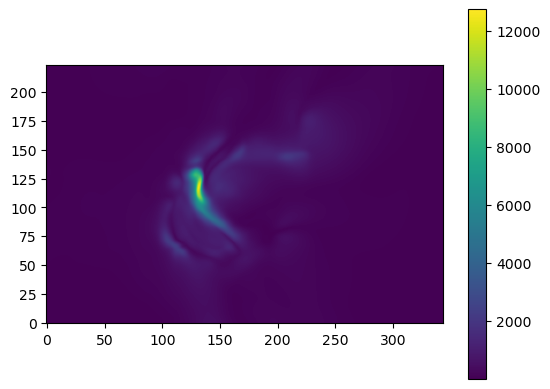

In [ ]:
plt.imshow(magnitude(j_pinn).sum(2).T, origin='lower')
plt.colorbar()

<matplotlib.colorbar.Colorbar>

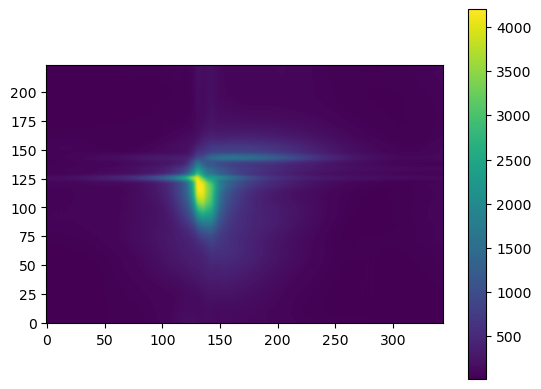

In [ ]:
plt.imshow(magnitude(j_spinn).sum(2).T, origin='lower')
plt.colorbar()

<matplotlib.colorbar.Colorbar>

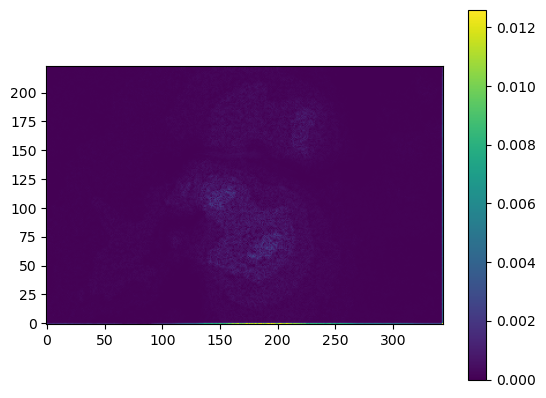

In [ ]:
plt.imshow(magnitude(j_pot).sum(2).T, origin='lower')
plt.colorbar()

<matplotlib.colorbar.Colorbar>

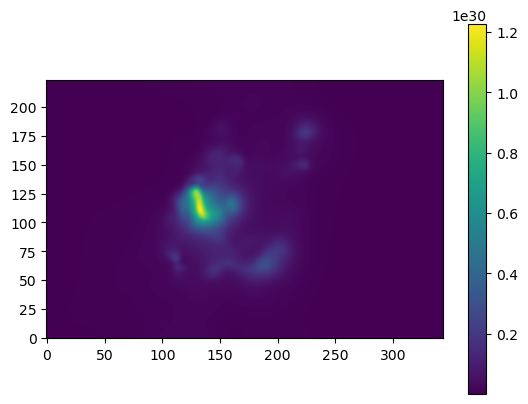

In [ ]:
plt.imshow(me_pinn.sum(2).T, origin='lower')
plt.colorbar()

<matplotlib.colorbar.Colorbar>

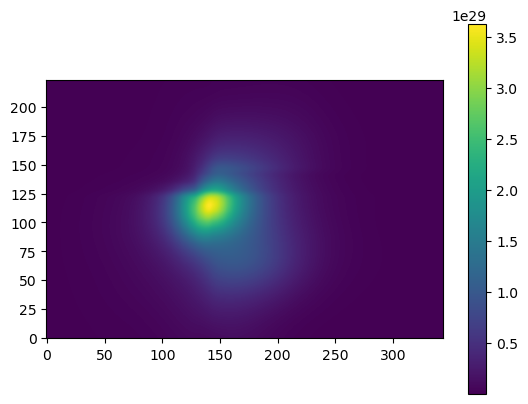

In [ ]:
plt.imshow(me_spinn.sum(2).T, origin='lower')
plt.colorbar()

<matplotlib.colorbar.Colorbar>

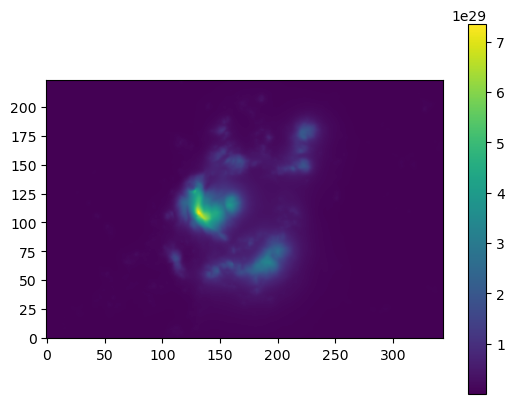

In [ ]:
plt.imshow(me_pot.sum(2).T, origin='lower')
plt.colorbar()

<matplotlib.colorbar.Colorbar>

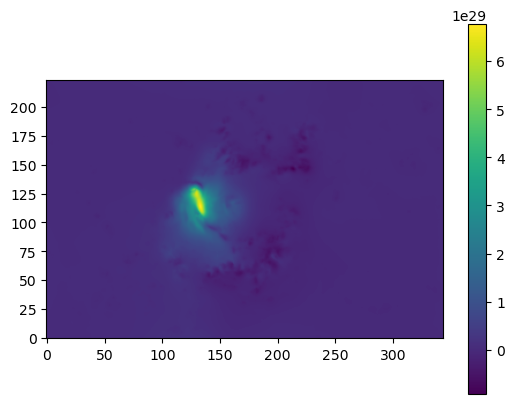

In [ ]:
plt.imshow(free_me_pinn.sum(2).T, origin='lower')
plt.colorbar()

<matplotlib.colorbar.Colorbar>

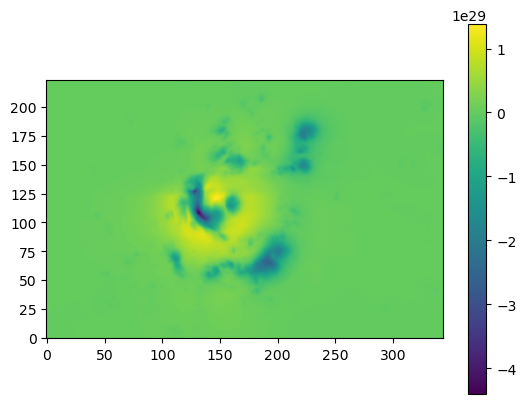

In [ ]:
plt.imshow(free_me_spinn.sum(2).T, origin='lower')
plt.colorbar()